### Import Module

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Prepare columns of interest and specify their types

In [39]:
# Init constant var to store desired cols and their types
DTYPE_DICT = {
    "user_id": pd.Int64Dtype(),
    "status": pd.StringDtype(),
    "timestamp": pd.Int64Dtype(),
    "data.user_data.meta.is_private": pd.BooleanDtype(),
    "data.user_data.meta.is_verified": pd.BooleanDtype(),
    "data.user_data.meta.is_business_account": pd.BooleanDtype(),
    "data.user_data.meta.is_professional_account": pd.BooleanDtype(),
    "data.user_data.meta.has_reel": pd.BooleanDtype(),
    "data.user_data.meta.total_posts_count": pd.Int64Dtype(),
    "data.user_data.meta.followers_count": pd.Int64Dtype(),
    "data.user_data.meta.followings_count": pd.Int64Dtype(),
}

# Iteratively get the metrics for posts
post_column_pattern = "data.user_data.post.{}.{}"
post_metrics = {
    "is_video": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "is_pinned": pd.BooleanDtype(),
}

# Populate DTYPE_DICT with desired metrics for 12 posts
for i in range(1, 13):
    for metric, dtype in post_metrics.items():
        column_name = post_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Iteratively get the metrics for reels
reel_column_pattern = "data.user_data.reel.{}.{}"
reel_metrics = {
    "has_audio": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "video_duration": pd.Float64Dtype(),
}
        
# Populate DTYPE_DICT with desired metrics for 36 reels
for i in range(1, 37):
    for metric, dtype in reel_metrics.items():
        column_name = reel_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Get a list of desired columns (for `read_csv()`)
columns_to_read = list(DTYPE_DICT.keys())

### Read Data

In [40]:
data = pd.read_csv('.././data/input/instagram.csv',
                  encoding='utf-8',
                  index_col=False,
                  usecols=columns_to_read,
                  dtype=DTYPE_DICT,)

### Filter Data Based on Account

Filter rows:
1. Failed jobs
2. Account with no reels
3. Private accounts
4. Accounts with total posts < 12
5. Accounts with followers < ? (1 for now)

Filter columns:
1. Post-related columns
2. Account type flags
3. Other irrelevant columns


In [41]:
# Filter out the following rows
data = data.loc[
    (data['status'] == 'successful') &
    (data['data.user_data.meta.has_reel'] == True) &
    (data['data.user_data.meta.is_private'] == False) &
    (data['data.user_data.meta.total_posts_count'] >= 12)
    & (data['data.user_data.meta.followers_count'] > 0)
]

# Filter out columns with names containing "data.user_data.post"
columns_to_drop = [col for col in data.columns if 'data.user_data.post' in col]

# Filter out unary cols
columns_to_drop.extend([
    'status',
    'data.user_data.meta.has_reel',
    'data.user_data.meta.is_private',
])

# Filter out other irrelevant columns
columns_to_drop.extend(
    [
        "data.user_data.meta.is_verified",
        "data.user_data.meta.is_business_account",
        "data.user_data.meta.is_professional_account",
    ]
)

data.drop(columns=columns_to_drop, inplace=True)
data

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,data.user_data.reel.1.has_audio,data.user_data.reel.1.video_view_count,data.user_data.reel.1.comments_count,data.user_data.reel.1.comments_disabled,data.user_data.reel.1.taken_at_timestamp,...,data.user_data.reel.35.taken_at_timestamp,data.user_data.reel.35.likes_count,data.user_data.reel.35.video_duration,data.user_data.reel.36.has_audio,data.user_data.reel.36.video_view_count,data.user_data.reel.36.comments_count,data.user_data.reel.36.comments_disabled,data.user_data.reel.36.taken_at_timestamp,data.user_data.reel.36.likes_count,data.user_data.reel.36.video_duration
0,1293559,1722469534,1422,2488,2112,True,1051,1,False,1722370215,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1256735,1722469583,1614,27160,5358,True,2144,1,False,1721673822,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1334585,1722469667,250,552,278,True,232,0,False,1722373466,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,1104262,1722469699,642,2214,1784,True,1322,0,False,1722407648,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,1206869,1722469734,55,702,1232,True,987,5,False,1720877897,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,1284932,1722570803,135,4996,5258,True,3073,33,False,1710255431,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2744,1331319,1722570821,786,1679,2410,True,109,0,False,1722531756,...,1674162607,37,51.633,True,172,1,False,1673911308,42,61.633
2745,1274132,1722570839,229,1518,2238,True,356,1,False,1717043239,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2747,1333719,1722570885,51,737,765,True,568,4,False,1704155392,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Transform Account-based dataframe into Reel-based dataframe

In [42]:
melted = data.melt(
    id_vars=[
        "user_id",
        "timestamp",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
    ],
    var_name="variable",
    value_name="value",
)
melted[["reel_id", "field"]] = melted["variable"].str.extract(r"reel\.(\d+)\.(.+)")
melted.sort_values(["user_id", "reel_id", "field"])

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,variable,value,reel_id,field
4439,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_count,0,1,comments_count
6535,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_disabled,False,1,comments_disabled
247,1018408,1722473971,742,984,643,data.user_data.reel.1.has_audio,True,1,has_audio
10727,1018408,1722473971,742,984,643,data.user_data.reel.1.likes_count,6,1,likes_count
8631,1018408,1722473971,742,984,643,data.user_data.reel.1.taken_at_timestamp,1722459602,1,taken_at_timestamp
...,...,...,...,...,...,...,...,...,...
118318,1445323,1722544589,12,522,110,data.user_data.reel.9.has_audio,<NA>,9,has_audio
128798,1445323,1722544589,12,522,110,data.user_data.reel.9.likes_count,<NA>,9,likes_count
126702,1445323,1722544589,12,522,110,data.user_data.reel.9.taken_at_timestamp,<NA>,9,taken_at_timestamp
130894,1445323,1722544589,12,522,110,data.user_data.reel.9.video_duration,<NA>,9,video_duration


In [43]:
# Pivot table
transformed = melted.pivot(
    index=[
        "user_id",
        "reel_id",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
        "timestamp",
    ],
    columns="field",
    values="value",
).reset_index()

# Reassign reel metrics types
for column, dtype in reel_metrics.items():
    transformed[column] = transformed[column].astype(dtype)
transformed["reel_id"] = transformed["reel_id"].astype(pd.Int64Dtype())

# Rename index and columns
transformed.columns.name = None
transformed = transformed.rename(
    columns={
        "timestamp": "scraped_at",
        "taken_at_timestamp": "created_at",
        "data.user_data.meta.total_posts_count": "total_posts",
        "data.user_data.meta.followers_count": "followers",
        "data.user_data.meta.followings_count": "followings",
    }
)

# Convert epoch timestamp to datetime objects
transformed['created_at_timestamp'] = transformed["created_at"]
transformed['created_at'] = pd.to_datetime(transformed['created_at'], unit='s', utc=True)
transformed['created_at_pst'] = transformed['created_at'].dt.tz_convert('America/Los_Angeles')
transformed['scraped_at_timestamp'] = transformed["scraped_at"]
transformed['scraped_at'] = pd.to_datetime(transformed['scraped_at'], unit='s', utc=True)
transformed['scraped_at_pst'] = transformed['scraped_at'].dt.tz_convert('America/Los_Angeles')

transformed

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,comments_disabled,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,False,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75451,1445323,5,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
75452,1445323,6,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
75453,1445323,7,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
75454,1445323,8,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00


### Summarize cleaned data set

In [63]:
def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    summary = []
    for col in df.columns:
        column_data = df[col]
        col_summary = {
            "Column": col,
            "Data Type": column_data.dtype,
            "NA %": column_data.isna().mean() * 100,
            "Unique Values": column_data.nunique(),
            "Mean": column_data.mean() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Median": column_data.median() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Min": column_data.min() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Max": column_data.max() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Range": (column_data.max() - column_data.min()) if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Top Frequency": column_data.value_counts().iloc[0] if not column_data.isna().all() else None,
        }
        
        # Handle boolean columns
        if column_data.dtype in [pd.BooleanDtype(), bool]:
            true_count = column_data.sum()
            false_count = len(column_data) - column_data.isna().sum() - true_count
            col_summary["True Count"] = true_count
            col_summary["False Count"] = false_count
            col_summary["True %"] = (true_count / (true_count + false_count)) * 100
            col_summary["False %"] = (false_count / (true_count + false_count)) * 100
        summary.append(col_summary)

    return pd.DataFrame(summary)

# Get summary
summarize_dataframe(transformed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2096,1.217091e+06,1.225812e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.850000e+01,1.850000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2096,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,5.699408e+02,3.685000e+02,1.200000e+01,3.075500e+04,3.074300e+04,324,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1507,3.058590e+03,1.055500e+03,2.000000e+01,5.908050e+05,5.907850e+05,252,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.295563e+03,9.120000e+02,0.000000e+00,7.535000e+03,7.535000e+03,216,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2072,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,33.233938,182,3.377439e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23412,NaN,NaN,NaN,NaN
7,comments_disabled,boolean,33.233938,2,NaN,NaN,NaN,NaN,NaN,50374,5.0,50374.0,0.009925,99.990075
8,has_audio,boolean,33.235263,2,NaN,NaN,NaN,NaN,NaN,47054,47054.0,3324.0,93.401882,6.598118
9,likes_count,Int64,33.233938,722,6.402598e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3125,NaN,NaN,NaN,NaN


### Filter reels
1. Unknown posting time
2. Comments disabled
3. Video duration < 1 seconds

In [45]:
# Drop rows with N/A created_at timestamp
cleaned = transformed.dropna(subset=["created_at"])

# Drop rows with comment disabled and remove this unary column
cleaned = cleaned[cleaned["comments_disabled"] == False].drop(columns=["comments_disabled"])

# Drop rows with video duration < 1 or is NA
cleaned = cleaned[(cleaned["video_duration"] >= 1) & ~(cleaned["video_duration"].isna())]

# Preview
summarize_dataframe(cleaned)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2096,1.217374e+06,1.224850e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.471006e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2096,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.998651e+02,4.770000e+02,1.200000e+01,3.075500e+04,3.074300e+04,220,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1507,3.693603e+03,1.230000e+03,2.000000e+01,5.908050e+05,5.907850e+05,159,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.453541e+03,1.073000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2072,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,182,3.378682e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23394,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,47035,47035.0,3316.0,93.414232,6.585768
8,likes_count,Int64,0.000000,722,6.404921e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3124,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,48825,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN


### Prepare columns

#### 1. Time elapsed from posted time to scraped time (in seconds)

In [46]:
augmented = cleaned.copy()

# Free useless dfs from memory
# del data, melted, transformed, cleaned
# import gc; gc.collect()

# Calculate the time difference between scraped_at and created_at
augmented["time_elapsed"] = augmented["scraped_at"] - augmented["created_at"]
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00,0 days 03:59:29
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00,113 days 03:22:47
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00,126 days 03:53:21
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75419,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04
75420,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20
75431,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52
75442,1445323,3,12,522,110,2024-08-01 20:36:29+00:00,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,1622163121,2021-05-27 17:52:01-07:00,1722544589,2024-08-01 13:36:29-07:00,1161 days 19:44:28


Plot and see the distribution of time elapsed

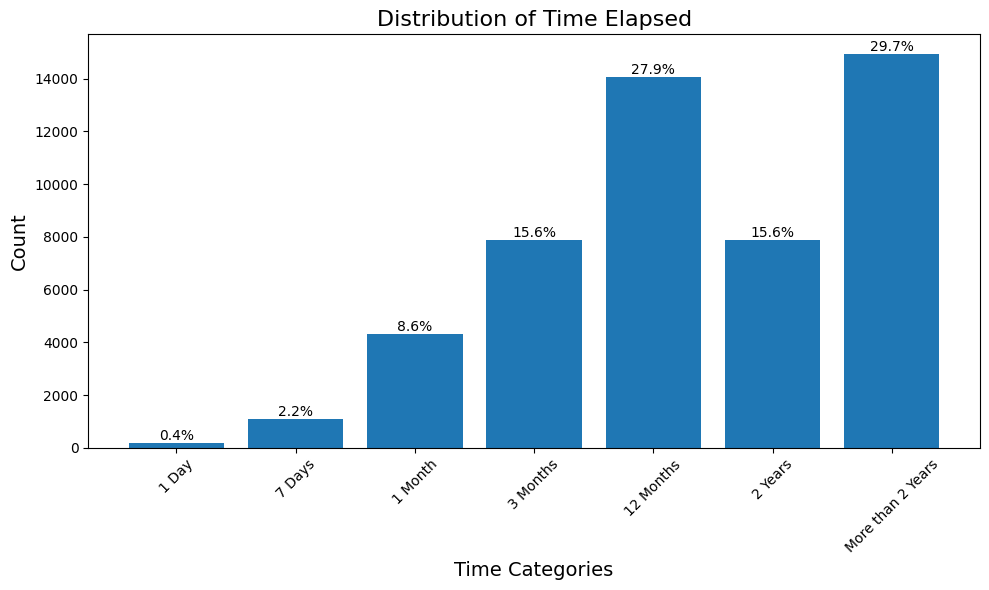

In [47]:
# Define the bin edges (in days) and labels
bins = [
    0, 
    1,             # 1 Day
    7,             # 7 Days
    30,            # 1 Month
    90,            # 3 Months
    365,           # 12 Months
    730,           # 2 Years
    float('inf')   # More than 2 Years
]
labels = [
    '1 Day', '7 Days', '1 Month', '3 Months', '12 Months', '2 Years', 'More than 2 Years',
]

# Create a new column for bins
augmented['time_elapsed_category'] = pd.cut(augmented['time_elapsed'].dt.days, bins=bins, labels=labels, right=False)

# Calculate distribution and percentages
distribution = augmented['time_elapsed_category'].value_counts().sort_index()
percentages = (distribution / len(augmented)) * 100

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(distribution.index.astype(str), distribution.values)

# Add percentage labels to each bar
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{percent:.1f}%", ha='center', va='bottom')

# Customize plot
ax.set_title("Distribution of Time Elapsed", fontsize=16)
ax.set_xlabel("Time Categories", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed,time_elapsed_category
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00,0 days 03:59:29,1 Day
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00,113 days 03:22:47,12 Months
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00,126 days 03:53:21,12 Months
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38,12 Months
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04,12 Months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75419,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04,12 Months
75420,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20,12 Months
75431,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52,More than 2 Years
75442,1445323,3,12,522,110,2024-08-01 20:36:29+00:00,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,1622163121,2021-05-27 17:52:01-07:00,1722544589,2024-08-01 13:36:29-07:00,1161 days 19:44:28,More than 2 Years


Take out reels that are less than 7 days old

We assume that reels after 7 days are receiving negligible amount of engagement, and those within posted 7 days (from the time the data was collected) are still receiving some. Since these reels consist of less than 3% of the total data, we decide to remove them.

A side note: is it more rational to make the engagement metric relative to the time elaspsed? For example, there's some scalar to be applied to reels posted within 1 day to predict what it would be like in the next week? Maybe not worth the time for just 3% of the data.

In [49]:
augmented = augmented[augmented['time_elapsed'] >= pd.Timedelta(days=7)]
# augmented.drop(columns=['time_elapsed_category'], inplace=True)  # Remove intermediate column
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2095,1.217443e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.502877e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.909585e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1506,3.597255e+03,1.228000e+03,2.000000e+01,5.908050e+05,5.907850e+05,154,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.449611e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2071,NaN,NaN,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,181,3.409961e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22591,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,45846,45846.0,3227.0,93.424082,6.575918
8,likes_count,Int64,0.000000,716,6.490577e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,47596,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN


#### 2. Categorize created_at into weekday

In [50]:
# Create day_of_week column (Monday=1, ..., Sunday=7) and converted to Int64Dtype
augmented = augmented.copy()
augmented['day_of_week_pst'] = augmented['created_at_pst'].dt.dayofweek + 1  # Adjust from 0-6 to 1-7
augmented['day_of_week_pst'] = augmented['day_of_week_pst'].astype(pd.Int64Dtype())

# Use cut to categorize time in PST
# Morning (4, 11]: 05:00 to 11:59
# Afternoon (11, 16]: 12:00 to 16:59
# Evening (16, 11]: 17:00 to 23:59
# Night (-1, 4]: 00:00 AM to 04:59
augmented['categorized_created_at_pst'] = pd.cut(
    augmented['created_at_pst'].dt.hour,
    bins=[-1, 4, 11, 16, 23],
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed,time_elapsed_category,day_of_week_pst,categorized_created_at_pst
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00,113 days 03:22:47,12 Months,2,Afternoon
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00,126 days 03:53:21,12 Months,3,Afternoon
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38,12 Months,5,Afternoon
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04,12 Months,5,Afternoon
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,True,7,2024-03-14 19:57:06+00:00,49.0,411,1710446226,2024-03-14 12:57:06-07:00,1722473971,2024-07-31 17:59:31-07:00,139 days 05:02:25,12 Months,4,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75419,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04,12 Months,3,Evening
75420,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20,12 Months,2,Afternoon
75431,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52,More than 2 Years,2,Evening
75442,1445323,3,12,522,110,2024-08-01 20:36:29+00:00,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,1622163121,2021-05-27 17:52:01-07:00,1722544589,2024-08-01 13:36:29-07:00,1161 days 19:44:28,More than 2 Years,4,Evening


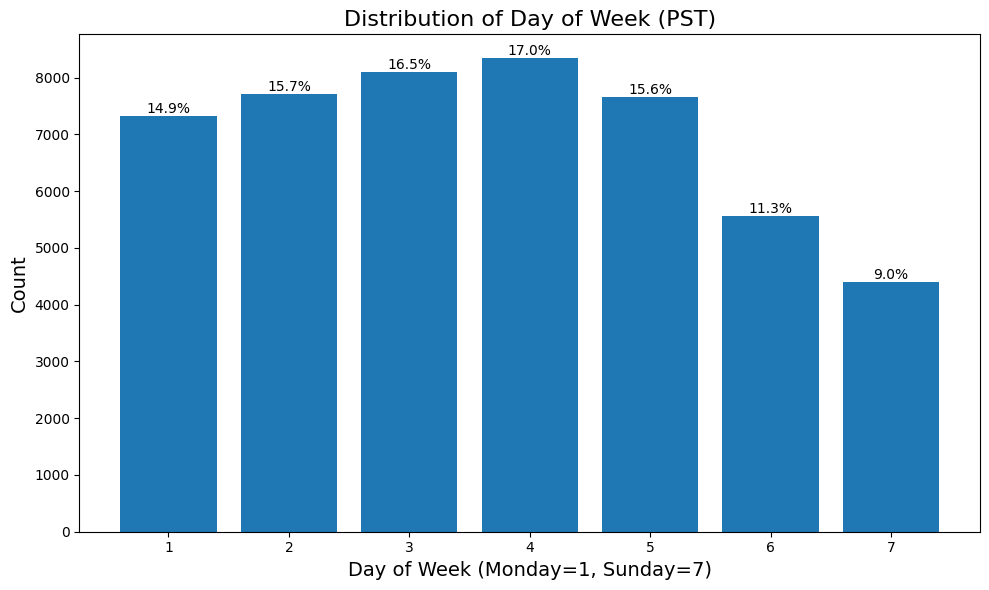

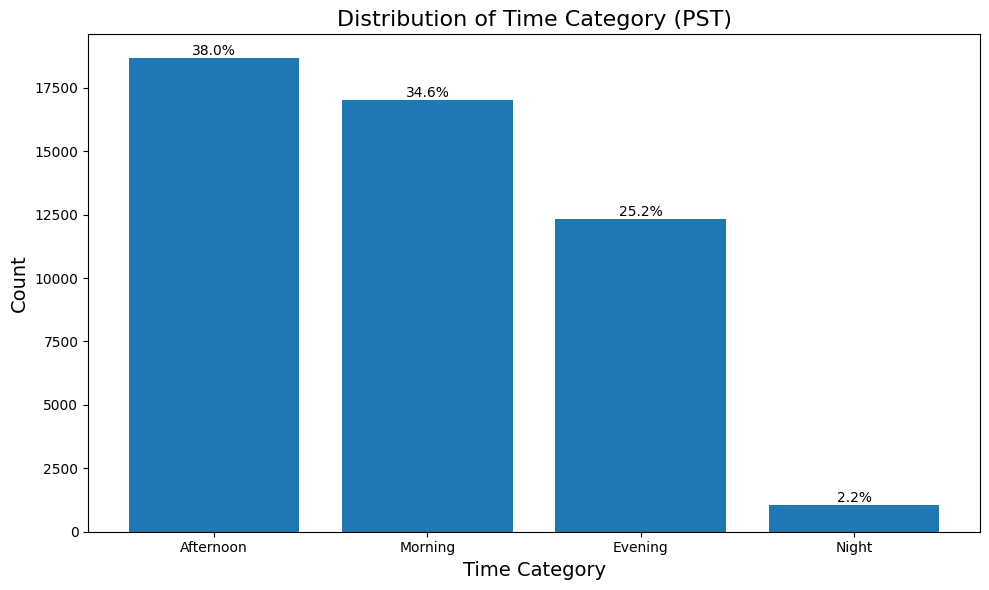

In [51]:
# Plot distribution of `day_of_week_pst`
day_of_week_counts = augmented['day_of_week_pst'].value_counts().sort_index()
day_of_week_percentages = (day_of_week_counts / len(augmented)) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(day_of_week_counts.index, day_of_week_counts.values, tick_label=day_of_week_counts.index)

for bar, percent in zip(bars, day_of_week_percentages):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax1.set_title("Distribution of Day of Week (PST)", fontsize=16)
ax1.set_xlabel("Day of Week (Monday=1, Sunday=7)", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

# Plot distribution of `time_category_pst`
time_category_counts = augmented['categorized_created_at_pst'].value_counts()
time_category_percentages = (time_category_counts / len(augmented)) * 100

fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(time_category_counts.index, time_category_counts.values, 
               tick_label=time_category_counts.index)

for bar, percent in zip(bars, time_category_percentages):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax2.set_title("Distribution of Time Category (PST)", fontsize=16)
ax2.set_xlabel("Time Category", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()


In [52]:
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2095,1.217443e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.502877e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.909585e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1506,3.597255e+03,1.228000e+03,2.000000e+01,5.908050e+05,5.907850e+05,154,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.449611e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2071,NaN,NaN,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,181,3.409961e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22591,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,45846,45846.0,3227.0,93.424082,6.575918
8,likes_count,Int64,0.000000,716,6.490577e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,47596,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN


### Handle NAs


Impute NAs in has_audio as True?
`cleaned_data["has_audio"] = cleaned_data["has_audio"].fillna(True)`

Impute NAs in video_view_count with the average ratio of video_view_count to like_count?


In [53]:
# Compare engagement metrics between videos with and without view counts
augmented.groupby(augmented['video_view_count'].isna())[["likes_count", "comments_count", "video_duration"]].describe()

# No obvious systematic differences in critical engagement metrics

likes_count                                                 \
                       count       mean          std  min   25%   50%   75%   
video_view_count                                                              
False                41489.0  70.753236  1975.619003  0.0   7.0  16.0  35.0   
True                  7584.0  32.916667     96.03158  0.0  10.0  20.0  38.0   

                           comments_count            ...               \
                       max          count      mean  ...  75%     max   
video_view_count                                     ...                
False             336276.0        41489.0    3.5836  ...  3.0  2863.0   
True                7177.0         7584.0  2.460047  ...  3.0   170.0   

                 video_duration                                             \
                          count       mean         std  min   25%      50%   
video_view_count                                                             
False                   41489.0  68.142523  126.978955  1.0  18.9   45.333   
True                     7584.0  60.738832   85.498234  1.0  14.7  37.1005   

                                     
                      75%       max  
video_view_count                     
False              82.433  9156.509  
True              61.7505  1965.645  

[2 rows x 24 columns]

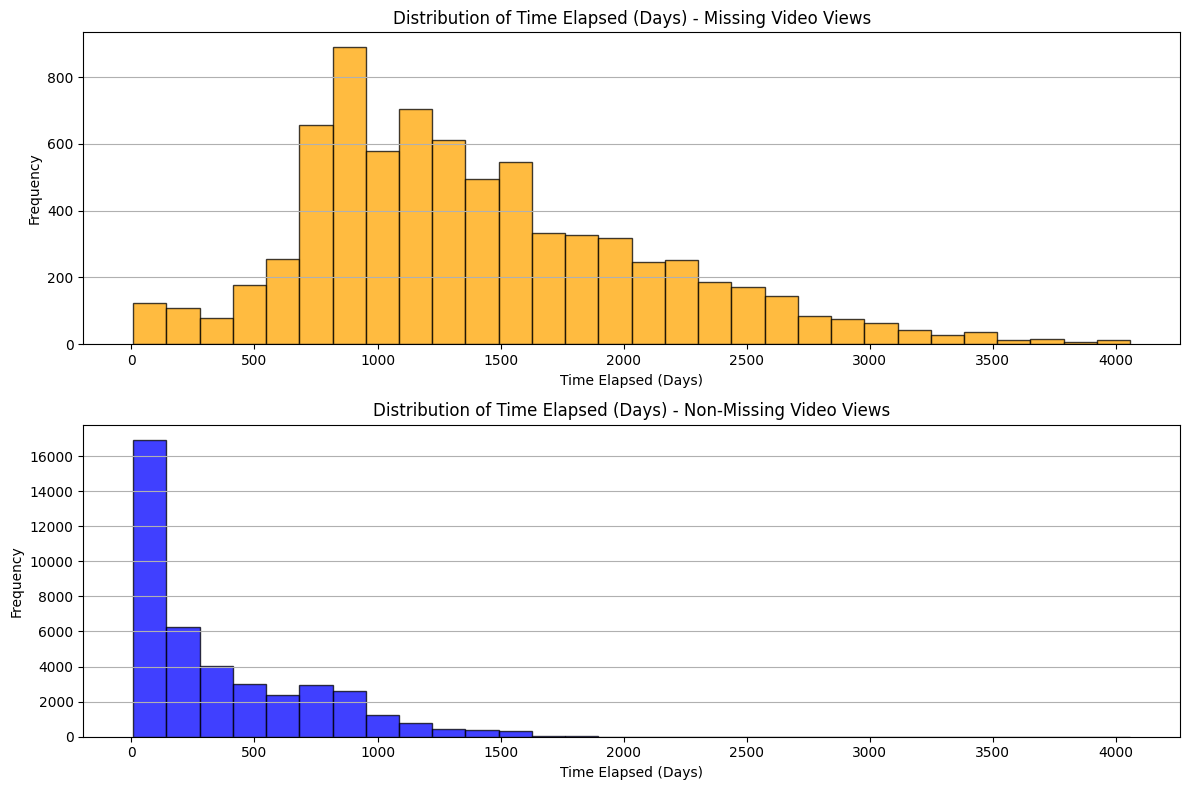

In [54]:
# Define common bin edges for the histos
bin_edges = np.histogram_bin_edges(
    pd.concat([augmented[augmented['video_view_count'].isna()]['time_elapsed'].dt.days, augmented[~augmented['video_view_count'].isna()]['time_elapsed'].dt.days]),
    bins=30
)

# Create figure
plt.figure(figsize=(12, 8))

# Plot histogram for missing `video_view_count`
plt.subplot(2, 1, 1)
plt.hist(
    augmented[augmented['video_view_count'].isna()]['time_elapsed'].dt.days, 
    bins=bin_edges, 
    alpha=0.75, 
    color='orange', 
    edgecolor='black'
)
plt.title('Distribution of Time Elapsed (Days) - Missing Video Views')
plt.xlabel('Time Elapsed (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Plot histogram for non-missing `video_view_count`
plt.subplot(2, 1, 2)
plt.hist(
    augmented[~augmented['video_view_count'].isna()]['time_elapsed'].dt.days, 
    bins=bin_edges, 
    alpha=0.75, 
    color='blue', 
    edgecolor='black'
)
plt.title('Distribution of Time Elapsed (Days) - Non-Missing Video Views')
plt.xlabel('Time Elapsed (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()

# Seems that the missingness was not random. It's more likely for an older reel to miss view counts. Maybe apply RF for imputation or just drop it (15% is a lot but it saves time and we still have about 40k rows).

### Try fitting a predictive model to impute NAs in video views

#### Preprocessing data

In [55]:
# Preprocess data
# Get time elasped in seconds
augmented["time_elapsed_seconds"] = augmented["time_elapsed"].dt.total_seconds()

# Encode has_audio
augmented["has_audio"] = augmented["has_audio"].astype(pd.Int64Dtype())

# One-Hot Encode 'day_of_week_pst' and 'categorized_created_at_pst'
day_of_week_dummies = pd.get_dummies(
    augmented["day_of_week_pst"],
    prefix="day",
    drop_first=True,  # Use Monday as reference
).astype(pd.Int64Dtype())
time_category_dummies = pd.get_dummies(
    augmented["categorized_created_at_pst"],
    prefix="time_cat",
    drop_first=True,  # Use Evening as reference
).astype(pd.Int64Dtype())

# Concatenate the dummy variables to the dataframe
augmented = pd.concat([augmented, day_of_week_dummies, time_category_dummies], axis=1)

# Define features selected
X_COLS = [
    "total_posts",
    "followers",
    "followings",
    # "comments_count",  # Removed due to the multicollinearity issue with likes_count
    "has_audio",  # Encoded into binary 0 or 1
    "likes_count",  # .9 correlation with views; assuming no data leakage;
    "video_duration",
    "time_elapsed_seconds",
    # "day_of_week_pst",  # One-hot encoded
    # "categorized_created_at_pst",  # One-hot encoded
] + list(day_of_week_dummies.columns) + list(time_category_dummies.columns)
Y_COL = "video_view_count"

# del day_of_week_dummies, time_category_dummies; gc.collect()

train_data = augmented[augmented["video_view_count"].notna()].copy()
missing_data = augmented[augmented["video_view_count"].isna()].copy()
train_data

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,...,time_elapsed_seconds,day_2,day_3,day_4,day_5,day_6,day_7,time_cat_Morning,time_cat_Afternoon,time_cat_Evening
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,1,7,2024-04-09 21:36:44+00:00,...,9775367.0,1,0,0,0,0,0,0,1,0
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,1,10,2024-03-27 21:06:10+00:00,...,10900401.0,0,1,0,0,0,0,0,1,0
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2024-03-15 21:46:53+00:00,...,11934758.0,0,0,0,1,0,0,0,1,0
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2024-03-15 21:34:27+00:00,...,11935504.0,0,0,0,1,0,0,0,1,0
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,1,7,2024-03-14 19:57:06+00:00,...,12027745.0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75416,1444154,6,692,509,486,2024-08-01 20:26:53+00:00,0,1,3,2024-01-20 22:30:58+00:00,...,16754155.0,0,0,0,0,1,0,0,1,0
75417,1444154,7,692,509,486,2024-08-01 20:26:53+00:00,0,1,4,2024-01-20 17:59:59+00:00,...,16770414.0,0,0,0,0,1,0,1,0,0
75418,1444154,8,692,509,486,2024-08-01 20:26:53+00:00,0,1,2,2024-01-20 03:43:11+00:00,...,16821822.0,0,0,0,1,0,0,0,0,1
75419,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,1,1,2024-01-18 02:54:49+00:00,...,16997524.0,0,1,0,0,0,0,0,0,1


#### Examine distributions

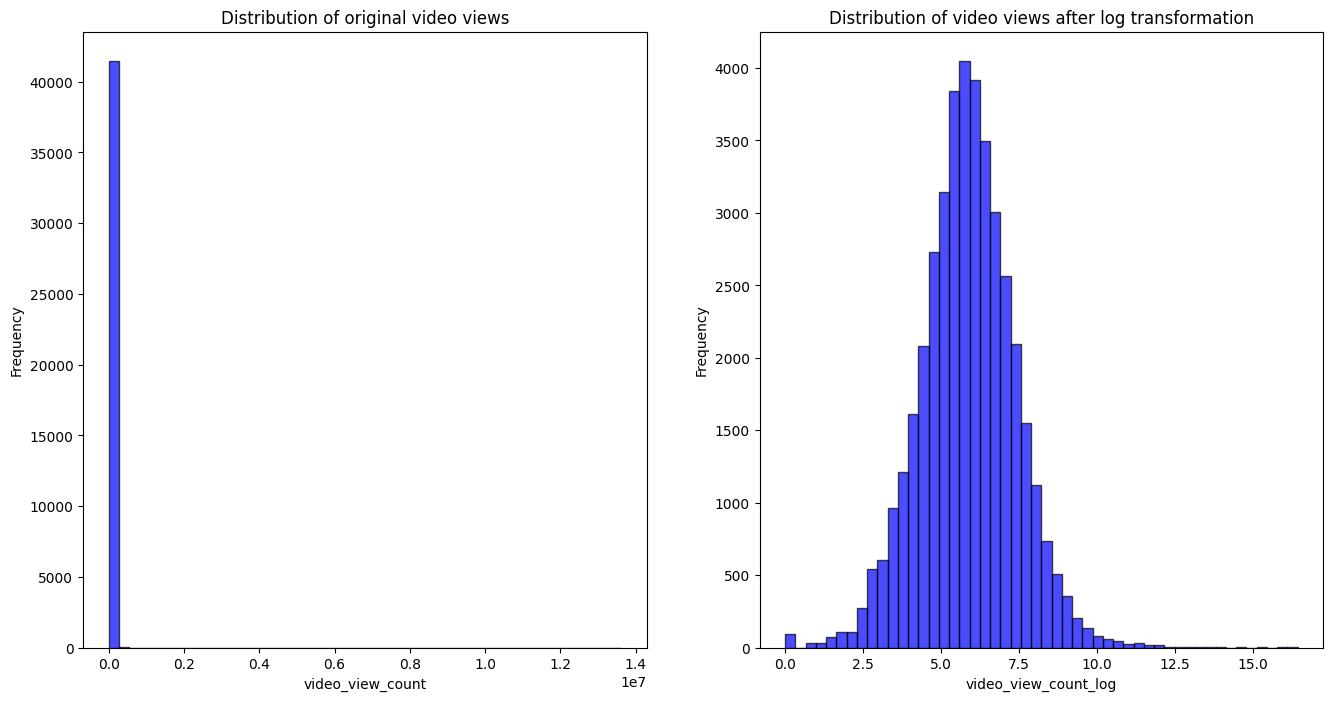

In [56]:
# Plot distribution
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.hist(train_data[Y_COL], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of original video views')
plt.xlabel('video_view_count')
plt.ylabel('Frequency')
# plt.show()

# Highly skewed to the right
train_data['video_view_count_log'] = np.log1p(train_data[Y_COL])  # Get log(1+x) as view can be 0
Y_COL_TRANSFORMED = 'video_view_count_log'

# Plot again, satisfied
plt.subplot(1, 2, 2)
plt.hist(train_data[Y_COL_TRANSFORMED], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of video views after log transformation')
plt.xlabel('video_view_count_log')
plt.ylabel('Frequency')
plt.show()

#### Examine correlation

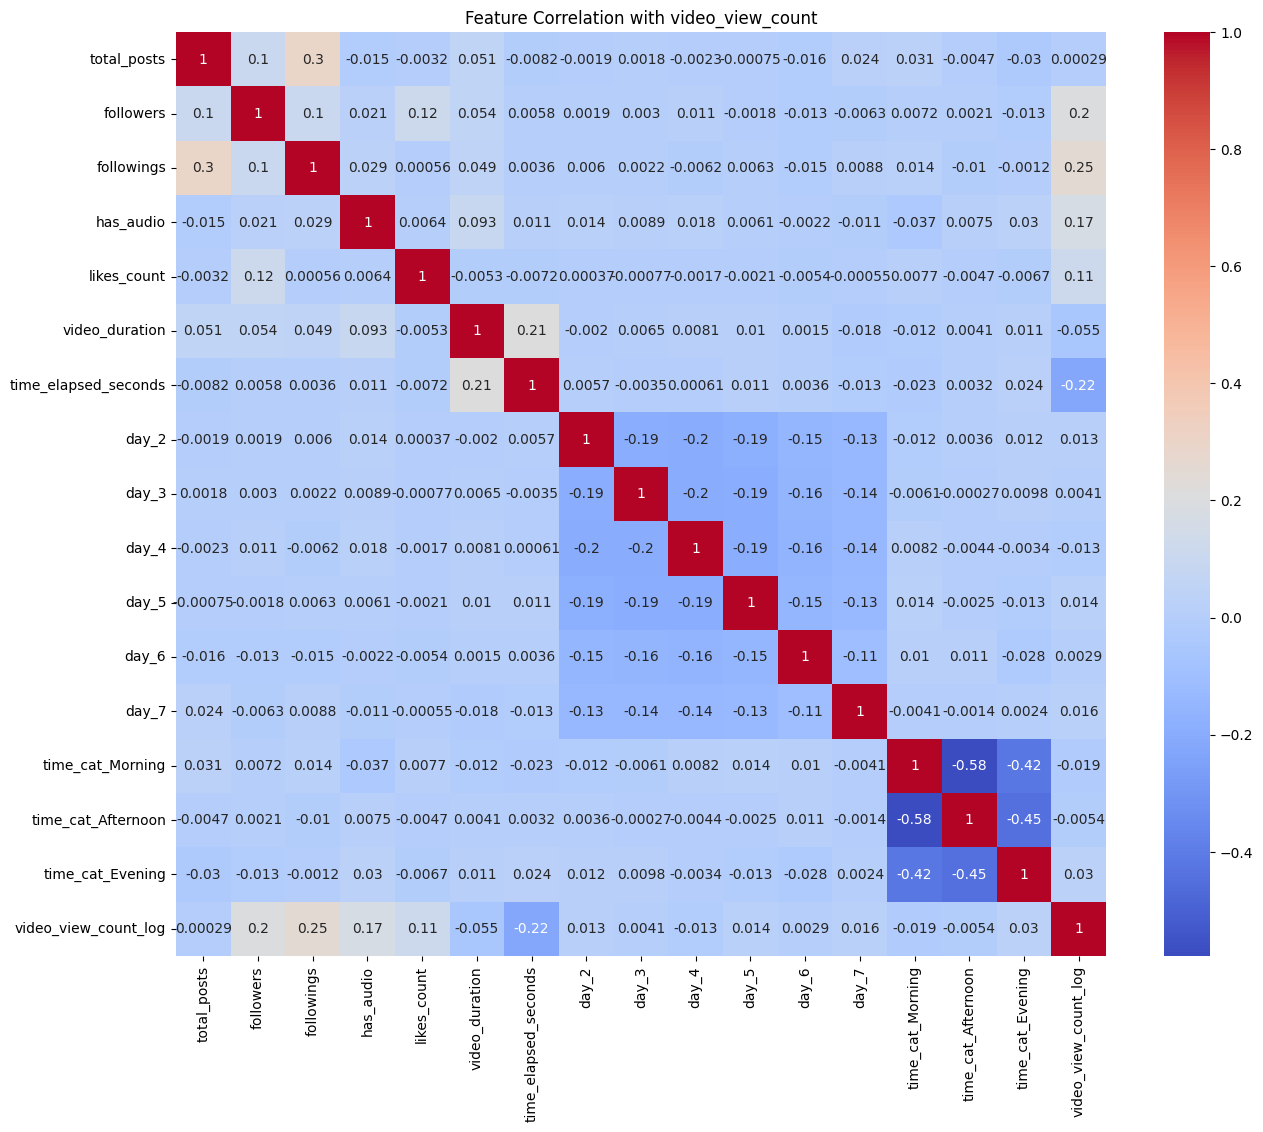

In [57]:
import seaborn as sns
corr_matrix = train_data[X_COLS + [Y_COL_TRANSFORMED]].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with video_view_count")
plt.show()

# High positive correlation found in likes_count and comments_count (0.73); Dropping comments_count;

# High negative correlation found in time_cat (around -0.50) is normal due to the nature of one-hot encoding.
# It's not a concern in RF. But in case other models (e.g., linear regression), it might introduce multicollinearty issues.
# So we drop the first categories in time_cat (and day_of_week, because why not) to reduce potential multicollinearity.

### Fit a Random Forest

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = train_data[X_COLS]
y = train_data[Y_COL_TRANSFORMED]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

# Used hyperparameters tuned by Grid and Randomized CV Search
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,  # Make reproducible
)
rf.fit(X_train, y_train)  # Takes about 1 minutes?
rf.score(X_valid, y_valid)  # R-squared Score: 0.8273

0.8273045264228309

#### (Optional) Tuning Hyperparameters
Run with caution!! Takes about 9 minutes to search.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5],
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
)
# grid_search_rf.fit(X_train, y_train)
# print(f'Grid Best Random Forest parameters: {grid_search_rf.best_params_}')
# print("="*33)
# Grid Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

# Try also RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
# random_search_rf.fit(X_train, y_train)
# print(f'Randomized Best Random Forest parameters: {random_search_rf.best_params_}')
# Randomized Best Random Forest parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  12.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.5s
[CV] END ma

/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  12.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estim

/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.4min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  17.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  17.5s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; tot

### Model Evaluation and Validation

Suppose that the random forest is the best model. We place the imputed values back to `augmented`.

In [65]:
# Generate predictions on missing data
imputed_log_views = rf.predict(missing_data[X_COLS])

# Convert the logged views back
imputed_values = np.expm1(imputed_log_views).round().astype(int)  # Since we used p1, we use m1 here
imputed = augmented.copy()
imputed["is_view_count_imputed"] = imputed[Y_COL].isna().astype(pd.Int64Dtype())
imputed.loc[augmented[Y_COL].isna(), Y_COL] = imputed_values
summarize_dataframe(imputed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,user_id,Int64,0.0,2095,1.217443e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36
1,reel_id,Int64,0.0,36,1.502877e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1920
2,total_posts,Int64,0.0,1022,6.909585e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217
3,followers,Int64,0.0,1506,3.597255e+03,1.228000e+03,2.000000e+01,5.908050e+05,5.907850e+05,154
4,followings,Int64,0.0,1430,1.449611e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143
5,scraped_at,"datetime64[s, UTC]",0.0,2071,NaN,NaN,NaN,NaN,NaN,71
6,comments_count,Int64,0.0,181,3.409961e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22591
7,has_audio,Int64,0.0,2,9.342408e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,45846
8,likes_count,Int64,0.0,716,6.490577e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3015
9,created_at,"datetime64[s, UTC]",0.0,47596,NaN,NaN,NaN,NaN,NaN,4


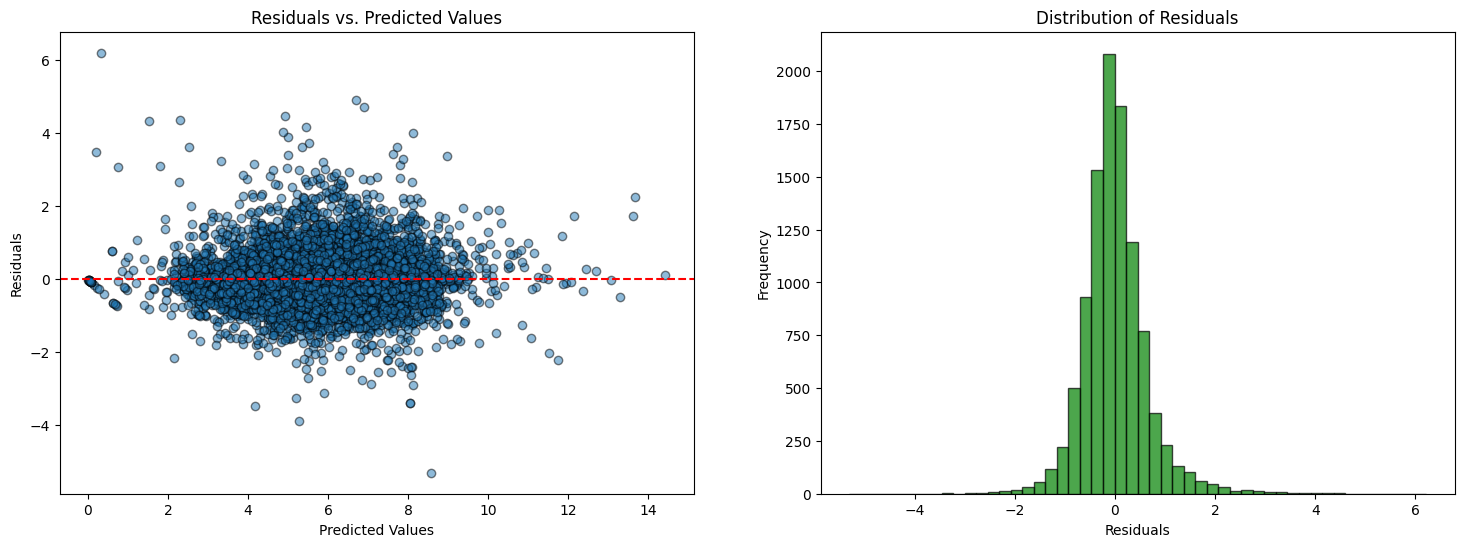

In [60]:
# Calculate residuals
residuals = y_valid - rf.predict(X_valid)

# Scatter plot of residuals vs. predicted values
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.scatter(rf.predict(X_valid), residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

# Distribution of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# The RF model appears well fitted, with residuals having no clear pattern, supporting the linearity and equal-variance assumption.

### Output CSV

In [ ]:
# columns_to_drop = [] + list(day_of_week_dummies.columns) + list(time_category_dummies.columns)
# imputed.drop(columns=columns_to_drop).to_csv("../data/processed/cleaned.csv")